In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from constants import FIGSIZE

In [42]:
# CCD data ([mm], [px])
empty, x_arr,hor, vert, avrg_beamwaist_array = np.loadtxt(
    fname='data/Kaustik/Kaustik_1_e^2.csv',
    delimiter=';',
    skiprows=2
).T
#w = halbe Strahlbreite bei I = I_max/e^2
hor, vert, avrg_beamwaist_array = hor/2, vert/2, avrg_beamwaist_array/2

# Pixel size of the camera [10^-6 m]
px_size = 5.6e-6

# Convert the beamwaist array to meter
avrg_beamwaist_array *= px_size

# Convert the x array to meter
x_arr *= 1/1000

# Path length before the lens [m]
d_exit_mirror__mirror_1 = 10.3e-2
d_mirror_1__mirror_2 = 25.0e-2
d_mirror_2__lens = 29.5e-2

d_exit_mirror__lens = sum([
    d_exit_mirror__mirror_1,
    d_mirror_1__mirror_2,
    d_mirror_2__lens
])

# Error for individual length measurement [m]
std_d = 3e-3
# Error for 4 combined length measurements -> sqrt(4) = 2
std_distance = 2 * std_d
#Error for individual beamwaist 1px = 100%
std_hv = 1/np.sqrt(3)
#Error for averadge beamwaist 
std_bw = std_hv/np.sqrt(2)

In [43]:
#Fit theoretical caustic

#caustic before lense
def before_lense(x, w_0, f, s ,lam):
    w = np.sqrt(w_0**2 + lam**2 * x**2 / np.pi**2 / w_0**2)
    return(w)

#caustic after lense
def after_lense(x, w_0, f, s ,lam):
    
    b = lam/(np.pi * w_0**2)
    x_square = x**2 * ((1+ (b**2 * s**2))/f**2 - 2* b**2 * s/f + b**2)
    x_ = 2*x*(s* b**2 - (1 + b**2 * s**2)/f)
    w = w_0*np.sqrt(x_square + x_ + 1 + b**2 * s**2)
    return(w)
#initial parameters
w_0 = 283.8 *1e-6
f= 0.15
s = d_exit_mirror__lens
lam = 632.8 * 1e-9
p_0 = np.asanyarray((w_0, f, s, lam))

#parameter boundaries in percent deviation from initial guess
bound = (1000,20, 5, 0.0001)
bound = np.asarray(bound)
bounds=(p_0-np.multiply(p_0,bound/100),p_0+np.multiply(p_0,bound/100))
#fit
popt, pcov = curve_fit(after_lense, x_arr, avrg_beamwaist_array, p0 = p_0, bounds=bounds)
print(popt)
print((popt-p_0)/popt*100)
perr = np.sqrt(np.diag(pcov))
print(perr/popt*100)

[3.49404497e-04 1.51802331e-01 6.43199591e-01 6.32800011e-07]
[ 1.87760884e+01  1.18728812e+00 -7.46332644e-01  1.75310037e-06]
[1.13439092e+06 2.67730937e+05 1.27086886e+05 7.55686318e+01]


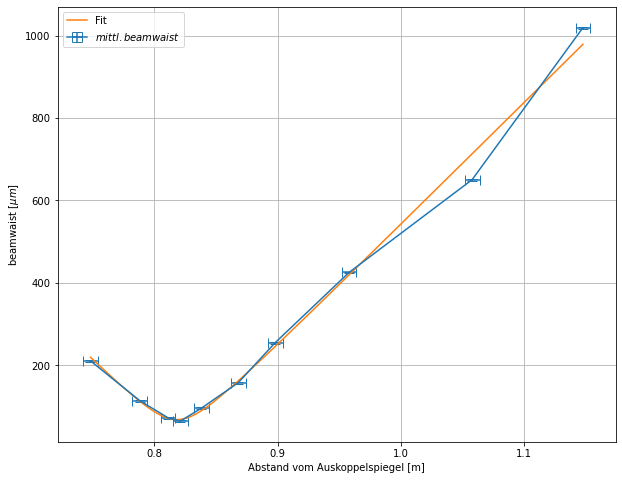

In [40]:
"""Plot des Fit nach der Linse"""
#adding up s and x
x_arr_sum = x_arr + d_exit_mirror__lens

# Create plot
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_xlabel('Abstand vom Auskoppelspiegel [m]')
ax.set_ylabel('beamwaist [$ \\mu m$]')
ax.grid()

# Plot measurements, convert beam size to micrometer
ax.errorbar(x=x_arr_sum, xerr=std_distance, y=avrg_beamwaist_array * 1e6, yerr=std_bw*px_size*1e6, label='$mittl. beamwaist$', capsize=5)

#standard deviation for fit parameters
popt_up = popt + perr
popt_dw = popt - perr

#Plot fit
x = np.linspace(x_arr.min(), x_arr.max(),300)
#ax.plot(x+d_exit_mirror__lens, after_lense(x, *popt_up)*1e6)
#ax.plot(x+d_exit_mirror__lens, after_lense(x, *popt_dw)*1e6)
ax.plot(x+d_exit_mirror__lens, after_lense(x, *popt)*1e6, label = "Fit")

ax.legend()

In [44]:
fig.savefig('figs/aufgabe1.3c_nachLinse.pdf', bbox_inches='tight')

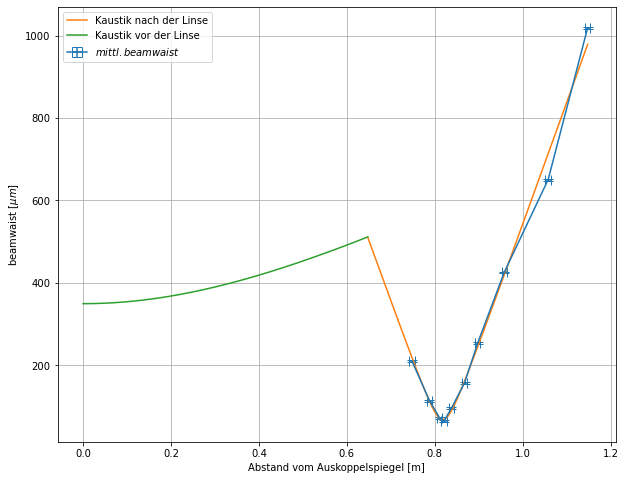

In [45]:
"""Plot des Fits vor und nach der Linse mit optimierten Parametern"""
#adding up s and x
x_arr_sum = x_arr + d_exit_mirror__lens

x_before_lense = np.linspace(0, d_exit_mirror__lens, 300)

# Create plot
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_xlabel('Abstand vom Auskoppelspiegel [m]')
ax.set_ylabel('beamwaist [$ \\mu m$]')
ax.grid()

# Plot measurements, convert beam size to micrometer
ax.errorbar(x=x_arr_sum, xerr=std_distance, y=avrg_beamwaist_array * 1e6, yerr=std_bw*px_size*1e6, label='$mittl. beamwaist$', capsize=5)

#standard deviation for fit parameters
popt_up = popt + perr
popt_dw = popt - perr

#Plot fit
x = np.linspace(0, x_arr.max(),300)
#ax.plot(x+d_exit_mirror__lens, after_lense(x, *popt_up)*1e6)
#ax.plot(x+d_exit_mirror__lens, after_lense(x, *popt_dw)*1e6)
ax.plot(x+d_exit_mirror__lens, after_lense(x, *popt)*1e6, label = "Kaustik nach der Linse")
ax.plot(x_before_lense, before_lense(x_before_lense, *popt)*1e6, label = "Kaustik vor der Linse")

ax.legend()

In [46]:
fig.savefig('figs/aufgabe1.3c_gesamt.pdf', bbox_inches='tight')

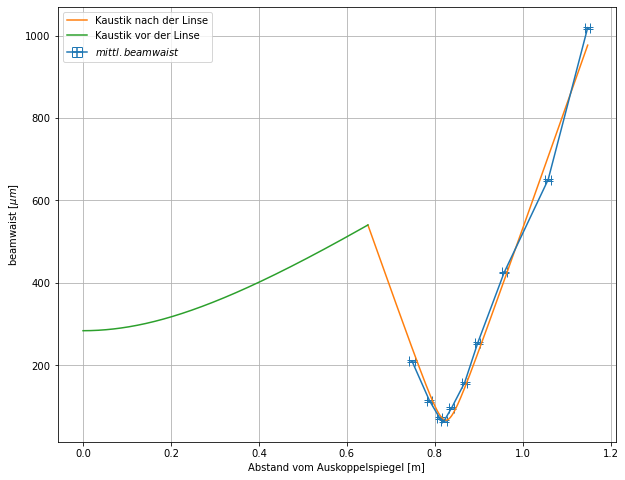

In [47]:
"""Plot des Fits vor und nach der Linse mit berechneter Strahltaille und gegebenen Parametern"""

#adding up s and x
x_arr_sum = x_arr + d_exit_mirror__lens

x_before_lense = np.linspace(0, d_exit_mirror__lens, 300)

# Create plot
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_xlabel('Abstand vom Auskoppelspiegel [m]')
ax.set_ylabel('beamwaist [$ \\mu m$]')
ax.grid()

# Plot measurements, convert beam size to micrometer
ax.errorbar(x=x_arr_sum, xerr=std_distance, y=avrg_beamwaist_array * 1e6, yerr=std_bw*px_size*1e6, label='$mittl. beamwaist$', capsize=5)

#standard deviation for fit parameters
popt_up = popt + perr
popt_dw = popt - perr

#Plot fit
x = np.linspace(0, x_arr.max(),300)
#ax.plot(x+d_exit_mirror__lens, after_lense(x, *popt_up)*1e6)
#ax.plot(x+d_exit_mirror__lens, after_lense(x, *popt_dw)*1e6)
ax.plot(x+d_exit_mirror__lens, after_lense(x, *p_0)*1e6, label = "Kaustik nach der Linse")
ax.plot(x_before_lense, before_lense(x_before_lense, *p_0)*1e6, label = "Kaustik vor der Linse")

ax.legend()

In [48]:
fig.savefig('figs/aufgabe1.3c_gesamt_geg.pdf', bbox_inches='tight')